# MEGADOCK on Google Colaboratory
**Protein-protein docking with MEGADOCK on Google Colaboratory**  
**MEGADOCKによるタンパク質間ドッキングをGoogle Colaboratoryで実行する**  

> 💻 MEGADOCK 4   https://github.com/akiyamalab/MEGADOCK  
> 📃 Ohue M, _et al_. **_Bioinformatics_**, 30(22): 3281-3283, 2014. http://doi.org/10.1093/bioinformatics/btu532  
> License: MEGADOCK is licensed by CC BY-NC 4.0. MEGADOCK and its derivatives are NOT allowed for any commercial use without formal prior authorization by Tokyo Institute of Technology.

**Input protein PDB IDs and chain names, then hit `Runtime` → `Run all`.**  
**入力する2つのタンパク質のPDB IDとchain名を入力し、 `ランタイム` → `すべてのセルを実行` をクリックしてください。**

In [ ]:
#@markdown **Receptor PDB** (`-R`)
R_pdb_id = "1CGI" #@param {type:"string"}
R_chain = "E" #@param {type:"string"}
#@markdown **Ligand PDB** (`-L`)
L_pdb_id = "1CGI" #@param {type:"string"}
L_chain = "I" #@param {type:"string"}

#@markdown MEGADOCK parameters (if you want to change)
t = "3" #@param {type:"string"}
#D = 0 #@param {type:"string"}
N = "10800" #@param {type:"string"}
outfile_name = "dock.out" #@param {type:"string"}

In [ ]:
#@title Check GPU (nvidia-smi)
!nvidia-smi

In [ ]:
#@title Install MEGADOCK
!git clone https://github.com/akiyamalab/MEGADOCK
!git clone https://github.com/NVIDIA/cuda-samples
!apt-get install -y libfftw3-dev libfftw3-single3

%cd ./MEGADOCK
!make -j 2 -f Makefile.colab

In [ ]:
#@title PDB preparation
import os
os.system(f"wget https://files.rcsb.org/download/{R_pdb_id}.pdb")
os.system(f"wget https://files.rcsb.org/download/{L_pdb_id}.pdb")

!pip install biopython
from Bio.PDB import *
strr = PDBParser().get_structure(R_pdb_id, R_pdb_id+".pdb")
strl = PDBParser().get_structure(L_pdb_id, L_pdb_id+".pdb")

io = PDBIO()
for chain in strr.get_chains():
  if chain.get_id() == R_chain:
    pdbr = strr.get_id() + "_" + chain.get_id() + ".pdb"
    io.set_structure(chain)
    io.save(pdbr)

for chain in strl.get_chains():
  if chain.get_id() == L_chain:
    pdbl = strl.get_id() + "_" + chain.get_id() + ".pdb"
    io.set_structure(chain)
    io.save(pdbl)

In [ ]:
#@title MEGADOCK parameter setting
os.environ['MDt'] = str(t)
os.environ['MDN'] = str(N)
os.environ['MDPDBR'] = pdbr
os.environ['MDPDBL'] = pdbl
os.environ['MDOF'] = str(outfile_name)

In [ ]:
#@title Run MEGADOCK
!./megadock-gpu -R $MDPDBR -L $MDPDBL -t $MDt -N $MDN -o $MDOF

In [ ]:
#@title Show the 1st solution on PDB viewer (NGLView)
!./decoygen lig.1.pdb $MDPDBL $MDOF 1
!cat $MDPDBR lig.1.pdb | sed 's/END//g' > complex1.pdb
!pip install nglview
from google.colab import output
output.enable_custom_widget_manager()
import nglview as nv
view = nv.show_structure_file("complex1.pdb")
view

In [ ]:
#@title PPI score calculation (for protein-protein interaction prediction)
!./ppiscore $MDOF $MDN

The value of the PPI Score (the value of $E$ in the above cell) can predict whether two protein chains will interact or not.  
The approximate values of precision (positive predictive value, PPV) and PPI Score are shown in the Figure below.  
* The precision is about 10% when $E > 8$ is predicted as "PPI positive."
* The precision is about 50% when $E > 10$ is predicted as "PPI positive."
* The precision is about 80% when $E > 12$ is predicted as "PPI positive."

PPI Scoreの値（上のセルの $E$ の値）で2つのタンパク質鎖が相互作用するかどうかを予測することができます。  
適合率 (precision, 陽性的中率) とPPI Scoreの目安は以下の図に示されるような値となります。  
*   $E > 8$ を「PPI有り」と予測した場合のprecisionは約10%
*   $E > 10$ を「PPI有り」と予測した場合のprecisionは約50%
*   $E > 12$ を「PPI有り」と予測した場合のprecisionは約80%

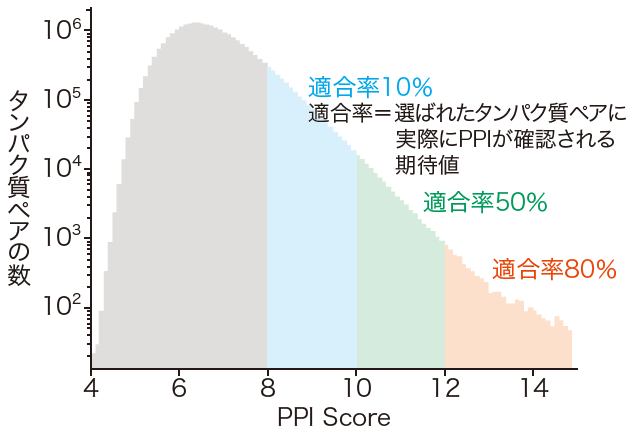  
(from Ohue M, _et al_. _Jikkenigaku_, 37(9):1469, 2019.)